In [4]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import os
import io

import numpy as np
import random
import math
import time
import pandas as pd

In [6]:
df = pd.read_csv("datos_2.csv")
df = df.drop([0,1,2,3,4])
df = df.reset_index().drop(['index'], axis = 1)
att_dict = {'apo':'absolute_price_oscillator',
            'bop':'balance_of_power',
            'cci':'cci',
            'cmo':'chande_momentum_oscillator',
            'ppo':'percentage_price_oscillator',
            'macd':'macd',
            'wr6':'wr_6',
            'rsi6':'rsi_6',
            'so':'stochastic_oscillator',
            'tema':'tema',
            'tr':'tr',
            'atr':'atr'}
data = df[['volume', 'amount',
       'absolute_price_oscillator', 'balance_of_power', 'cci',
       'chande_momentum_oscillator', 'percentage_price_oscillator', 'macd',
       'wr_6', 'rsi_6', 'stochastic_oscillator', 'tema', 'tr', 'atr']].values

closes = df['close'].values

In [3]:
data = (data.max() - data)/(data.max()-data.min())
closes = (closes.max() - closes)/(closes.max()-closes.min())

In [4]:
T = 10
input_list = []
output_list = []
for i in range(0,data.shape[0]-T):
    input_list.append(data[i:i+T])
    output_list.append(closes[i+1:i+T+1]) 
input_tensor = np.array(input_list)
target_tensor = np.array(output_list)
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

In [5]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
#embedding_dim = 256
units = 1024


dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [6]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 10, 14]), TensorShape([64, 10]))

In [7]:
class Encoder(tf.keras.Model):
    def __init__(self, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        output, state = self.gru(x, initial_state = hidden)
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [8]:
encoder = Encoder(units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 10, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [9]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        # query hidden state shape == (batch_size, hidden size)
        # query_with_time_axis shape == (batch_size, 1, hidden size)
        # values shape == (batch_size, max_len, hidden size)
        # we are doing this to broadcast addition along the time axis to calculate the score
        query_with_time_axis = tf.expand_dims(query, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(
            self.W1(query_with_time_axis) + self.W2(values)))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [10]:
attention_layer = BahdanauAttention(16)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 10, 1)


In [11]:
class Decoder(tf.keras.Model):
    def __init__(self, dec_units, batch_sz, T):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(T, activation='relu')

        # used for attention
        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):
        # enc_output shape == (batch_size, max_length, hidden_size)
        context_vector, attention_weights = self.attention(hidden, enc_output)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        #print('en decoder',context_vector.shape, x.shape)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([context_vector, x], axis=-1)
        x = tf.expand_dims(x,1)
        # passing the concatenated vector to the GRU
        output, state = self.gru(x)
        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))
        
        # output shape == (batch_size, vocab)
        x = self.fc(output)

        return x, state, attention_weights

In [12]:
decoder = Decoder(units, BATCH_SIZE, T)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE,1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 10)


In [13]:
optimizer = tf.keras.optimizers.Adam()
#loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
#    from_logits=True, reduction='none')

loss_object = tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error")


def loss_function(real, pred):
    real = tf.expand_dims(real,1)
    
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [14]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [15]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0

    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)
        dec_hidden = enc_hidden
        
        #dec_input = tf.expand_dims([1.0] * BATCH_SIZE, 1,18)
        dec_input = tf.ones((64,1))
        # Teacher forcing - feeding the target as the next input
        
        for t in range(1, targ.shape[1]):
            # passing enc_output to the decoder
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
            
            
            
            loss += loss_function(targ[:, t], predictions)
            #print('target,futuro dec_inmput',targ[:, t].shape)
            # using teacher forcing
            dec_input = tf.expand_dims(targ[:, t], 1)
            
    batch_loss = (loss / int(targ.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [16]:
EPOCHS = 20

for epoch in range(EPOCHS):
    start = time.time()

    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss

        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
    # saving (checkpoint) the model every 2 epochs
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                  total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 0.2908
Epoch 1 Loss 0.0673
Time taken for 1 epoch 86.77141618728638 sec

Epoch 2 Batch 0 Loss 0.0473
Epoch 2 Loss 0.0429
Time taken for 1 epoch 74.94668102264404 sec

Epoch 3 Batch 0 Loss 0.0394
Epoch 3 Loss 0.0394
Time taken for 1 epoch 77.29545593261719 sec

Epoch 4 Batch 0 Loss 0.0383
Epoch 4 Loss 0.0052
Time taken for 1 epoch 74.40621542930603 sec

Epoch 5 Batch 0 Loss 0.0021
Epoch 5 Loss 0.0021
Time taken for 1 epoch 74.9291820526123 sec

Epoch 6 Batch 0 Loss 0.0021
Epoch 6 Loss 0.0014
Time taken for 1 epoch 77.29984474182129 sec

Epoch 7 Batch 0 Loss 0.0016
Epoch 7 Loss 0.0013
Time taken for 1 epoch 79.85920071601868 sec

Epoch 8 Batch 0 Loss 0.0011
Epoch 8 Loss 0.0011
Time taken for 1 epoch 75.18562269210815 sec

Epoch 9 Batch 0 Loss 0.0009
Epoch 9 Loss 0.0012
Time taken for 1 epoch 74.17047190666199 sec

Epoch 10 Batch 0 Loss 0.0011
Epoch 10 Loss 0.0011
Time taken for 1 epoch 75.68747520446777 sec

Epoch 11 Batch 0 Loss 0.0009
Epoch 11 Loss 0.0011
Time take

In [17]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

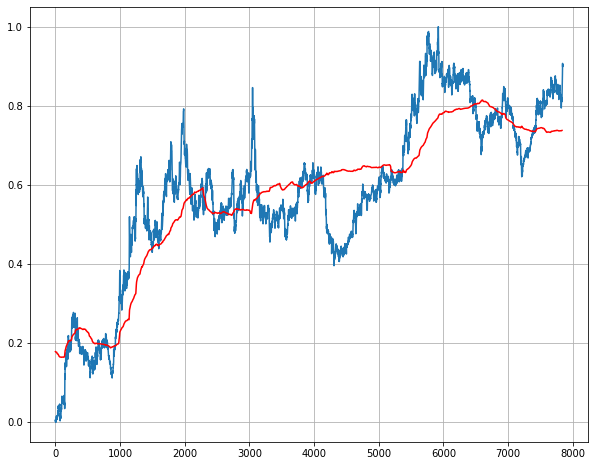

In [18]:
plt.figure(figsize=(10,8))
predicciones = []
plt.plot(closes)
for i in range(1,input_tensor.shape[0]):
    inputs = tf.convert_to_tensor(input_tensor[i-1:i])

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([1.0], 1)
    

    predictions, dec_hidden, attention_weights = decoder(dec_input,dec_hidden,enc_out)
    predicciones.append(np.array(predictions).mean())
plt.plot(predicciones, c='r')
plt.grid()
plt.show()

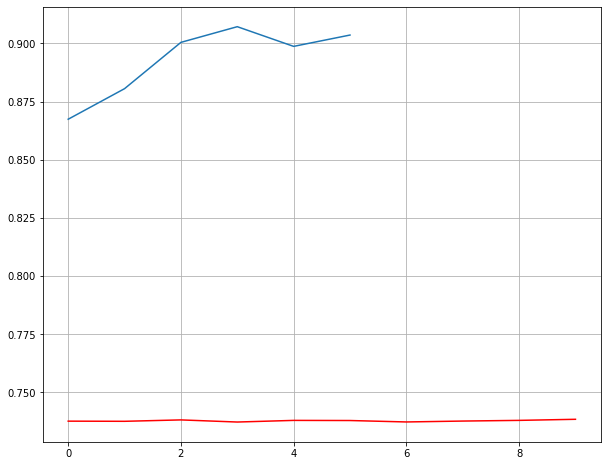

In [20]:
plt.figure(figsize=(10,8))

inputs = tf.convert_to_tensor(input_tensor[-1:])

hidden = [tf.zeros((1, units))]
enc_out, enc_hidden = encoder(inputs, hidden)

dec_hidden = enc_hidden
dec_input = tf.expand_dims([1.0], 1)


predictions, dec_hidden, attention_weights = decoder(dec_input,dec_hidden,enc_out)
plt.plot(closes[-6:])
plt.plot(np.array(predictions)[0], c='r')
plt.grid()
plt.show()